# Studying Wikipedia Page Protections
This notebook provides a tutorial for how to study [page protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy) on Wikipedia either via the [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) or [API](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo). It has three stages:
* Accessing the Page Protection dumps
* Accessing the Page Protection API
* Example analysis of page protection data (both descriptive statistics and learning a predictive model)

## Accessing the Page Protection Dumps
This is an example of how to parse through [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) and determine [what sorts of edit protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy#Overview_of_types_of_protection) are applied to a given Wikipedia article.

In [255]:
# TODO: add other libraries here as necessary
import gzip  # necessary for decompressing dump file into text format
import json
import os
import time
import pprint
import matplotlib.pyplot as plt


In [57]:
### Every language on Wikipedia has its own page restrictions table
# you can find all the dbnames (e.g., enwiki) here: https://www.mediawiki.org/w/api.php?action=sitematrix
# for example, you could replace the LANGUAGE parameter of 'enwiki' with 'arwiki' to study Arabic Wikipedia
LANGUAGE = 'enwiki'
# e.g., enwiki -> en.wikipedia (this is necessary for the API section)
SITENAME = LANGUAGE.replace('wiki', '.wikipedia')
print(SITENAME)
# directory on PAWS server that holds Wikimedia dumps
DUMP_DIR = "/public/dumps/public/{0}/latest/".format(LANGUAGE)
DUMP_FN = '{0}-latest-page_restrictions.sql.gz'.format(LANGUAGE)

en.wikipedia


In [58]:
# The dataset isn't huge -- 1.1 MB -- so should be quick to process in full
!ls -shH "{DUMP_DIR}{DUMP_FN}"

1.1M /public/dumps/public/enwiki/latest/enwiki-latest-page_restrictions.sql.gz


In [59]:
# Inspect the first 1000 characters of the page protections dump to see what it looks like
# As you can see from the CREATE TABLE statement, each datapoint has 7 fields (pr_page, pr_type, ... , pr_id)
# A description of the fields in the data can be found here:
#   https://www.mediawiki.org/wiki/Manual:Page_restrictions_table
# And the data that we want is on lines that start with INSERT INTO `page_restrictions` VALUES...
# The first datapoint (1086732,'edit','sysop',0,NULL,'infinity',1307) can be interpreted as:
#   1086732:    page ID 1086732 (en.wikipedia.org/wiki/?curid=1086732)
#   'edit':     has edit protections
#   'sysop':    that require sysop permissions (https://en.wikipedia.org/wiki/Wikipedia:User_access_levels#Administrator)
#   0:          does not cascade to other pages
#   NULL:       no user-specific restrictions
#   'infinity': restriction does not expire automatically
#   1307:       table primary key -- has no meaning by itself

!zcat "{DUMP_DIR}{DUMP_FN}" | head -1000  | cut -c1-500

-- MySQL dump 10.16  Distrib 10.1.45-MariaDB, for debian-linux-gnu (x86_64)
--
-- Host: 10.64.48.13    Database: enwiki
-- ------------------------------------------------------
-- Server version	10.1.43-MariaDB

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;

--
-- Table structure for table `page_restrictions`
--

DROP TABLE IF EXISTS `page_restrictions`;
/*!40101 SET @saved_cs_client     = @@character_set_client */;
/*!40101 SET character_set_c

In [271]:
a=[]
with gzip.open(os.path.join(DUMP_DIR, DUMP_FN), 'rt') as raw:
    for line in raw:
        line = line.strip()
        if line.lower().startswith('insert'):
            line=line.replace('INSERT INTO `page_restrictions` VALUES', '')
            line_part=line[0:1000] #select part of data
            match=re.findall('\(.*?\)',line_part)
            print(match)


["(1086732,'edit','sysop',0,NULL,'infinity',1307)", "(1086732,'move','sysop',0,NULL,'infinity',1308)", "(1266562,'edit','autoconfirmed',0,NULL,'infinity',1358)", "(1266562,'move','autoconfirmed',0,NULL,'infinity',1359)", "(1534334,'edit','autoconfirmed',0,NULL,NULL,1437)", "(1534334,'move','autoconfirmed',0,NULL,NULL,1438)", "(1654125,'edit','autoconfirmed',0,NULL,NULL,1664)", "(1654125,'move','autoconfirmed',0,NULL,NULL,1665)", "(1654622,'edit','autoconfirmed',0,NULL,NULL,1672)", "(1654622,'move','autoconfirmed',0,NULL,NULL,1673)", "(1654633,'edit','autoconfirmed',0,NULL,NULL,1674)", "(1654633,'move','autoconfirmed',0,NULL,NULL,1675)", "(1654645,'edit','autoconfirmed',0,NULL,NULL,1676)", "(1654645,'move','autoconfirmed',0,NULL,NULL,1677)", "(1654656,'edit','autoconfirmed',0,NULL,NULL,1682)", "(1654656,'move','autoconfirmed',0,NULL,NULL,1683)", "(1654662,'edit','autoconfirmed',0,NULL,NULL,1684)", "(1654662,'move','autoconfirmed',0,NULL,NULL,1685)", "(1654673,'edit','autoconfirmed',0,NU

In [211]:
NewList1= [[x] for x in match] #new list of lists containing selective elements of JSON dump(due to memory constraints)
print(NewList1)
            

[["(1234398,'edit','autoconfirmed',0,NULL,'20201102113828',867412)"], ["(56693098,'edit','autoconfirmed',0,NULL,'20201102124450',867416)"], ["(56693098,'move','autoconfirmed',0,NULL,'20201102124450',867417)"], ["(30610102,'edit','autoconfirmed',0,NULL,'20210102125424',867418)"], ["(30610102,'move','sysop',0,NULL,'infinity',867419)"], ["(17310869,'edit','extendedconfirmed',0,NULL,'20201102130028',867420)"], ["(5113872,'edit','autoconfirmed',0,NULL,'20201102130223',867421)"], ["(1610318,'edit','autoconfirmed',0,NULL,'20201102130249',867422)"], ["(64999857,'edit','autoconfirmed',0,NULL,'20201102132040',867430)"], ["(149129,'edit','autoconfirmed',0,NULL,'20211002135124',867431)"], ["(59720465,'edit','autoconfirmed',0,NULL,'20201102144115',867433)"], ["(59720465,'move','autoconfirmed',0,NULL,'20201102144115',867434)"], ["(65478380,'edit','autoconfirmed',0,NULL,'infinity',867435)"], ["(42376342,'edit','autoconfirmed',0,NULL,'20201102160757',867436)"], ["(19644,'edit','autoconfirmed',0,NULL,'

In [272]:
NewList1[0][0] #we can access each record by indexing

"(1234398,'edit','autoconfirmed',0,NULL,'20201102113828',867412)"

In [274]:
import pandas as pd
final_list_vals = []
NULL = 'None' #Since null isn't predefined in python, we replace it with None so eval() can be performes
len1=len(NewList1)
for i in range(0,len1): #iterate over the list of lists, since each member is 
    #of type string, eval() parses the expression passed to this method
    for lst in NewList1[i]:
        final_list_vals.append(eval(lst)) #now each record is stored in a new list
final_list_vals #this is in a format which we can convert to a dataframe

[(1234398, 'edit', 'autoconfirmed', 0, 'None', '20201102113828', 867412),
 (56693098, 'edit', 'autoconfirmed', 0, 'None', '20201102124450', 867416),
 (56693098, 'move', 'autoconfirmed', 0, 'None', '20201102124450', 867417),
 (30610102, 'edit', 'autoconfirmed', 0, 'None', '20210102125424', 867418),
 (30610102, 'move', 'sysop', 0, 'None', 'infinity', 867419),
 (17310869, 'edit', 'extendedconfirmed', 0, 'None', '20201102130028', 867420),
 (5113872, 'edit', 'autoconfirmed', 0, 'None', '20201102130223', 867421),
 (1610318, 'edit', 'autoconfirmed', 0, 'None', '20201102130249', 867422),
 (64999857, 'edit', 'autoconfirmed', 0, 'None', '20201102132040', 867430),
 (149129, 'edit', 'autoconfirmed', 0, 'None', '20211002135124', 867431),
 (59720465, 'edit', 'autoconfirmed', 0, 'None', '20201102144115', 867433),
 (59720465, 'move', 'autoconfirmed', 0, 'None', '20201102144115', 867434),
 (65478380, 'edit', 'autoconfirmed', 0, 'None', 'infinity', 867435),
 (42376342, 'edit', 'autoconfirmed', 0, 'None'

In [276]:
#convert the above list to a df
column_lst = ['pageid', 'type', 'level', 'cascade', 'user', 'expiry', 'key']
dump_df = pd.DataFrame(final_list_vals, columns=column_lst)
dump_df=dump_df.replace('None','NULL') #replace back with original value
dump_df

,pageid,type,level,cascade,user,expiry,key
0,1234398,edit,autoconfirmed,0,NULL,20201102113828,867412
1,56693098,edit,autoconfirmed,0,NULL,20201102124450,867416
2,56693098,move,autoconfirmed,0,NULL,20201102124450,867417
3,30610102,edit,autoconfirmed,0,NULL,20210102125424,867418
4,30610102,move,sysop,0,NULL,infinity,867419
5,17310869,edit,extendedconfirmed,0,NULL,20201102130028,867420
6,5113872,edit,autoconfirmed,0,NULL,20201102130223,867421
7,1610318,edit,autoconfirmed,0,NULL,20201102130249,867422
8,64999857,edit,autoconfirmed,0,NULL,20201102132040,867430
9,149129,edit,autoconfirmed,0,NULL,20211002135124,867431


### Accessing the Page Protection APIs

The Page Protection API can be a much simpler way to access data about page protections for a given article if you know what articles you are interested in and are interested in relatively few articles (e.g., hundreds or low thousands).

NOTE: the APIs are up-to-date while the Mediawiki dumps are always at least several days behind -- i.e. for specific snapshots in time -- so the data you get from the Mediawiki dumps might be different from the APIs if permissions have changed to a page's protections in the intervening days.

In [229]:
# TODO: add other libraries here as necessary
import mwapi  # useful for accessing Wikimedia API
import random

# TODO: Gather ten random page IDs from the data gathered from the Mediawiki dump to get data for from the API
ten_random_items = dump_df.sample(10, random_state = 1) 
print(ten_random_items)
ten_random_ids=list(ten_random_items['pageid'])
ten_random_ids

      pageid  type          level  cascade  user          expiry     key
3   30610102  edit  autoconfirmed        0  NULL  20210102125424  867418
13  42376342  edit  autoconfirmed        0  NULL  20201102160757  867436
7    1610318  edit  autoconfirmed        0  NULL  20201102130249  867422
2   56693098  move  autoconfirmed        0  NULL  20201102124450  867417
6    5113872  edit  autoconfirmed        0  NULL  20201102130223  867421
10  59720465  edit  autoconfirmed        0  NULL  20201102144115  867433
4   30610102  move          sysop        0  NULL        infinity  867419
1   56693098  edit  autoconfirmed        0  NULL  20201102124450  867416
14     19644  edit  autoconfirmed        0  NULL        infinity  867437
0    1234398  edit  autoconfirmed        0  NULL  20201102113828  867412


[30610102,
 42376342,
 1610318,
 56693098,
 5113872,
 59720465,
 30610102,
 56693098,
 19644,
 1234398]

In [230]:
ten_random_items=ten_random_items.reset_index().sort_values(by=['pageid'])
ten_random_ids=list(ten_random_items['pageid'])
ten_random_ids

[19644,
 1234398,
 1610318,
 5113872,
 30610102,
 30610102,
 42376342,
 56693098,
 56693098,
 59720465]

In [67]:
# mwapi documentation: https://pypi.org/project/mwapi/
# user_agent helps identify the request if there's an issue and is best practice
tutorial_label = 'Page Protection API tutorial (mwapi)'
# NOTE: it is best practice to include a contact email in user agents
# generally this is private information though so do not change it to yours
# if you are working in the PAWS environment or adding to a Github repo
# for Outreachy, you can leave this as my (isaac's) email or switch it to your Mediawiki username
# e.g., Isaac (WMF) for https://www.mediawiki.org/wiki/User:Isaac_(WMF)
contact_email = 'isaac@wikimedia.org'
session = mwapi.Session('https://en.wikipedia.org'.format('SITENAME'), user_agent='{0} -- {1}'.format(tutorial_label, contact_email))

# TODO: You'll have to add additional parameters here to query the pages you're interested in
# API endpoint: https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo
# More details: https://www.mediawiki.org/wiki/API:Info
params = {'action':'query',
          #'list':'allcategories',
          'prop':'info|revisions', 
          #'prop':'revisions',
          #'meta':'userinfo',
          'inprop':'protection|watchers',
          #'titles':'ids',
          'pageids': '19644|1234398|1610318|5113872|30610102|30610102|42376342|56693098|56693098|59720465',
          'format':'json'}

In [216]:
result = session.get(params)
pprint.pprint(result)

{'batchcomplete': '',
 'query': {'pages': {'1234398': {'contentmodel': 'wikitext',
                                 'lastrevid': 981609468,
                                 'length': 27067,
                                 'ns': 0,
                                 'pageid': 1234398,
                                 'pagelanguage': 'en',
                                 'pagelanguagedir': 'ltr',
                                 'pagelanguagehtmlcode': 'en',
                                 'protection': [{'expiry': '2020-11-02T11:38:28Z',
                                                 'level': 'autoconfirmed',
                                                 'type': 'edit'}],
                                 'restrictiontypes': ['edit', 'move'],
                                 'revisions': [{'comment': '/* Qualification '
                                                           '*/',
                                                'parentid': 981453753,
                            

In [278]:
result1=result['query']['pages']
api_df=pd.DataFrame.from_dict(result1) #convert the dict to a dataframe
(api_df)

,19644,1234398,1610318,5113872,30610102,42376342,56693098,59720465
pageid,19644,1234398,1610318,5113872,30610102,42376342,56693098,59720465
ns,0,0,0,0,0,0,0,0
title,Mein Kampf,FIFA U-17 World Cup,Bochasanwasi Akshar Purushottam Swaminarayan S...,Gunatitanand Swami,Bubble Guppies,SZA (singer),Bob the Builder (2015 TV series),List of Bob the Builder (2015 TV series) episodes
contentmodel,wikitext,wikitext,wikitext,wikitext,wikitext,wikitext,wikitext,wikitext
pagelanguage,en,en,en,en,en,en,en,en
pagelanguagehtmlcode,en,en,en,en,en,en,en,en
pagelanguagedir,ltr,ltr,ltr,ltr,ltr,ltr,ltr,ltr
touched,2020-10-29T23:46:58Z,2020-10-30T00:32:39Z,2020-10-30T01:32:24Z,2020-10-30T05:43:22Z,2020-10-31T01:15:34Z,2020-10-30T21:35:32Z,2020-10-26T12:36:19Z,2020-10-28T09:35:15Z
lastrevid,985385960,981609468,984764352,983976544,986306321,986279094,985409486,981474100
length,57459,27067,86562,36172,19636,55477,7328,53033


In [279]:
api_df=pd.DataFrame.from_dict(result1,orient='index') #make the rows as index (page id)
api_df=api_df.reset_index()
api_df.head(10)

,index,pageid,ns,title,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,protection,restrictiontypes,watchers,revisions
0,19644,19644,0,Mein Kampf,wikitext,en,en,ltr,2020-10-29T23:46:58Z,985385960,57459,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",497.0,"[{'revid': 985385960, 'parentid': 984452498, '..."
1,1234398,1234398,0,FIFA U-17 World Cup,wikitext,en,en,ltr,2020-10-30T00:32:39Z,981609468,27067,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",66.0,"[{'revid': 981609468, 'parentid': 981453753, '..."
2,1610318,1610318,0,Bochasanwasi Akshar Purushottam Swaminarayan S...,wikitext,en,en,ltr,2020-10-30T01:32:24Z,984764352,86562,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",71.0,"[{'revid': 984764352, 'parentid': 984763661, '..."
3,5113872,5113872,0,Gunatitanand Swami,wikitext,en,en,ltr,2020-10-30T05:43:22Z,983976544,36172,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",NaN,"[{'revid': 983976544, 'parentid': 981460532, '..."
4,30610102,30610102,0,Bubble Guppies,wikitext,en,en,ltr,2020-10-31T01:15:34Z,986306321,19636,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",77.0,"[{'revid': 986306321, 'parentid': 986235461, '..."
5,42376342,42376342,0,SZA (singer),wikitext,en,en,ltr,2020-10-30T21:35:32Z,986279094,55477,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",100.0,"[{'revid': 986279094, 'parentid': 982912923, '..."
6,56693098,56693098,0,Bob the Builder (2015 TV series),wikitext,en,en,ltr,2020-10-26T12:36:19Z,985409486,7328,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",NaN,"[{'revid': 985409486, 'parentid': 984096266, '..."
7,59720465,59720465,0,List of Bob the Builder (2015 TV series) episodes,wikitext,en,en,ltr,2020-10-28T09:35:15Z,981474100,53033,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",NaN,"[{'revid': 981474100, 'parentid': 981473021, '..."


Getting the Dump dataframe for same ten ids.

In [17]:
print(dump_df.pageid[0])

1234398


In [18]:
ten_random_ids

[19644,
 1234398,
 1610318,
 5113872,
 30610102,
 30610102,
 42376342,
 56693098,
 56693098,
 59720465]

### Comparison of Data between dump and API

In [232]:
ten_random_items=ten_random_items.reset_index() #Setting the index to be in range 0-9
ten_random_items.drop(columns=['index'], inplace=True)

In [233]:
ten_random_items.drop(columns=['level_0'],inplace=True)# drop unnecessary columns

In [277]:
ten_random_items

,pageid,type,level,cascade,user,expiry,key
0,19644,edit,autoconfirmed,0,NULL,infinity,867437
1,1234398,edit,autoconfirmed,0,NULL,20201102113828,867412
2,1610318,edit,autoconfirmed,0,NULL,20201102130249,867422
3,5113872,edit,autoconfirmed,0,NULL,20201102130223,867421
4,30610102,edit,autoconfirmed,0,NULL,20210102125424,867418
5,30610102,move,sysop,0,NULL,infinity,867419
6,42376342,edit,autoconfirmed,0,NULL,20201102160757,867436
7,56693098,move,autoconfirmed,0,NULL,20201102124450,867417
8,56693098,edit,autoconfirmed,0,NULL,20201102124450,867416
9,59720465,edit,autoconfirmed,0,NULL,20201102144115,867433


In [235]:
api_df

,index,pageid,ns,title,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,protection,restrictiontypes,watchers,revisions
0,19644,19644,0,Mein Kampf,wikitext,en,en,ltr,2020-10-29T23:46:58Z,985385960,57459,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",497.0,"[{'revid': 985385960, 'parentid': 984452498, '..."
1,1234398,1234398,0,FIFA U-17 World Cup,wikitext,en,en,ltr,2020-10-30T00:32:39Z,981609468,27067,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",66.0,"[{'revid': 981609468, 'parentid': 981453753, '..."
2,1610318,1610318,0,Bochasanwasi Akshar Purushottam Swaminarayan S...,wikitext,en,en,ltr,2020-10-30T01:32:24Z,984764352,86562,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",71.0,"[{'revid': 984764352, 'parentid': 984763661, '..."
3,5113872,5113872,0,Gunatitanand Swami,wikitext,en,en,ltr,2020-10-30T05:43:22Z,983976544,36172,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",NaN,"[{'revid': 983976544, 'parentid': 981460532, '..."
4,30610102,30610102,0,Bubble Guppies,wikitext,en,en,ltr,2020-10-31T01:15:34Z,986306321,19636,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",77.0,"[{'revid': 986306321, 'parentid': 986235461, '..."
5,42376342,42376342,0,SZA (singer),wikitext,en,en,ltr,2020-10-30T21:35:32Z,986279094,55477,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",100.0,"[{'revid': 986279094, 'parentid': 982912923, '..."
6,56693098,56693098,0,Bob the Builder (2015 TV series),wikitext,en,en,ltr,2020-10-26T12:36:19Z,985409486,7328,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",NaN,"[{'revid': 985409486, 'parentid': 984096266, '..."
7,59720465,59720465,0,List of Bob the Builder (2015 TV series) episodes,wikitext,en,en,ltr,2020-10-28T09:35:15Z,981474100,53033,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",NaN,"[{'revid': 981474100, 'parentid': 981473021, '..."


In [236]:
ap=api_df.copy() #making a  copy of dataframe so we can split the string values into separate columns
a=(ap['protection'].apply(pd.Series))
a

,0,1
0,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'sysop', 'expiry': '..."
1,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
2,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
3,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
4,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'sysop', 'expiry': '..."
5,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
6,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'autoconfirmed', 'ex..."
7,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'autoconfirmed', 'ex..."


In [237]:
a.rename(columns={0: 'type1', 1: 'type2'}, inplace=True)
a

,type1,type2
0,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'sysop', 'expiry': '..."
1,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
2,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
3,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
4,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'sysop', 'expiry': '..."
5,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...",NaN
6,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'autoconfirmed', 'ex..."
7,"{'type': 'edit', 'level': 'autoconfirmed', 'ex...","{'type': 'move', 'level': 'autoconfirmed', 'ex..."


In [238]:
a1=a['type1'].apply(pd.Series) #Now the edit protections have been separated into 3 columns
#.rename(columns={1: 'expiry1', 2: 'level1', 3:'type1'}, inplace=True)
a1

,type,level,expiry
0,edit,autoconfirmed,infinity
1,edit,autoconfirmed,2020-11-02T11:38:28Z
2,edit,autoconfirmed,2020-11-02T13:02:49Z
3,edit,autoconfirmed,2020-11-02T13:02:23Z
4,edit,autoconfirmed,2021-01-02T12:54:24Z
5,edit,autoconfirmed,2020-11-02T16:07:57Z
6,edit,autoconfirmed,2020-11-02T12:44:50Z
7,edit,autoconfirmed,2020-11-02T14:41:15Z


In [240]:
a1=a1.rename(columns={'expiry': 'expiry1', 'level': 'level1', 'type':'type1'}) 
#we rename the edit type as type1
a1 

,type1,level1,expiry1
0,edit,autoconfirmed,infinity
1,edit,autoconfirmed,2020-11-02T11:38:28Z
2,edit,autoconfirmed,2020-11-02T13:02:49Z
3,edit,autoconfirmed,2020-11-02T13:02:23Z
4,edit,autoconfirmed,2021-01-02T12:54:24Z
5,edit,autoconfirmed,2020-11-02T16:07:57Z
6,edit,autoconfirmed,2020-11-02T12:44:50Z
7,edit,autoconfirmed,2020-11-02T14:41:15Z


Rename the move type as type2


In [242]:
a2=a['type2'].apply(pd.Series)
a2=a2.rename(columns={'expiry': 'expiry2', 'level': 'level2', 'type':'type2'})
a2=a2.drop(columns=[0])

In [243]:
ap=pd.concat([ap.drop(['protection'], axis=1),a1,a2], axis=1)
api=ap.copy()
api

,index,pageid,ns,title,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,restrictiontypes,watchers,revisions,type1,level1,expiry1,expiry2,level2,type2
0,19644,19644,0,Mein Kampf,wikitext,en,en,ltr,2020-10-29T23:46:58Z,985385960,57459,"[edit, move]",497.0,"[{'revid': 985385960, 'parentid': 984452498, '...",edit,autoconfirmed,infinity,infinity,sysop,move
1,1234398,1234398,0,FIFA U-17 World Cup,wikitext,en,en,ltr,2020-10-30T00:32:39Z,981609468,27067,"[edit, move]",66.0,"[{'revid': 981609468, 'parentid': 981453753, '...",edit,autoconfirmed,2020-11-02T11:38:28Z,NaN,NaN,NaN
2,1610318,1610318,0,Bochasanwasi Akshar Purushottam Swaminarayan S...,wikitext,en,en,ltr,2020-10-30T01:32:24Z,984764352,86562,"[edit, move]",71.0,"[{'revid': 984764352, 'parentid': 984763661, '...",edit,autoconfirmed,2020-11-02T13:02:49Z,NaN,NaN,NaN
3,5113872,5113872,0,Gunatitanand Swami,wikitext,en,en,ltr,2020-10-30T05:43:22Z,983976544,36172,"[edit, move]",NaN,"[{'revid': 983976544, 'parentid': 981460532, '...",edit,autoconfirmed,2020-11-02T13:02:23Z,NaN,NaN,NaN
4,30610102,30610102,0,Bubble Guppies,wikitext,en,en,ltr,2020-10-31T01:15:34Z,986306321,19636,"[edit, move]",77.0,"[{'revid': 986306321, 'parentid': 986235461, '...",edit,autoconfirmed,2021-01-02T12:54:24Z,infinity,sysop,move
5,42376342,42376342,0,SZA (singer),wikitext,en,en,ltr,2020-10-30T21:35:32Z,986279094,55477,"[edit, move]",100.0,"[{'revid': 986279094, 'parentid': 982912923, '...",edit,autoconfirmed,2020-11-02T16:07:57Z,NaN,NaN,NaN
6,56693098,56693098,0,Bob the Builder (2015 TV series),wikitext,en,en,ltr,2020-10-26T12:36:19Z,985409486,7328,"[edit, move]",NaN,"[{'revid': 985409486, 'parentid': 984096266, '...",edit,autoconfirmed,2020-11-02T12:44:50Z,2020-11-02T12:44:50Z,autoconfirmed,move
7,59720465,59720465,0,List of Bob the Builder (2015 TV series) episodes,wikitext,en,en,ltr,2020-10-28T09:35:15Z,981474100,53033,"[edit, move]",NaN,"[{'revid': 981474100, 'parentid': 981473021, '...",edit,autoconfirmed,2020-11-02T14:41:15Z,2020-11-02T14:41:15Z,autoconfirmed,move


Now split up the revision property

In [244]:
r=api['revisions'].apply(pd.Series)
r

,0
0,"{'revid': 985385960, 'parentid': 984452498, 'm..."
1,"{'revid': 981609468, 'parentid': 981453753, 'u..."
2,"{'revid': 984764352, 'parentid': 984763661, 'm..."
3,"{'revid': 983976544, 'parentid': 981460532, 'u..."
4,"{'revid': 986306321, 'parentid': 986235461, 'u..."
5,"{'revid': 986279094, 'parentid': 982912923, 'm..."
6,"{'revid': 985409486, 'parentid': 984096266, 'm..."
7,"{'revid': 981474100, 'parentid': 981473021, 'm..."


In [245]:
r1=r[0].apply(pd.Series)
r1

,revid,parentid,minor,user,timestamp,comment
0,985385960,984452498,,GenoV84,2020-10-25T17:30:23Z,Expanded listnames to the main templates.
1,981609468,981453753,NaN,대한민국 헌법,2020-10-03T11:30:28Z,/* Qualification */
2,984764352,984763661,,Schazjmd,2020-10-21T23:37:54Z,removed unneeded commas
3,983976544,981460532,NaN,Redtigerxyz,2020-10-17T12:02:55Z,Importing Wikidata [[Wikipedia:Short descripti...
4,986306321,986235461,NaN,Scatman007,2020-10-31T01:15:34Z,/* Main characters */Removal of red links.
5,986279094,982912923,,FrescoBot,2020-10-30T21:35:00Z,Bot: [[User:FrescoBot/Links|link syntax]] and ...
6,985409486,984096266,,Neils51,2020-10-25T20:02:05Z,spelling
7,981474100,981473021,,MusikBot II,2020-10-02T14:50:20Z,Adding missing protection template ([[User:Mus...


In [246]:
api=pd.concat([api.drop(['revisions'], axis=1),r1], axis=1)
api.head(2)

,index,pageid,ns,title,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,...,expiry1,expiry2,level2,type2,revid,parentid,minor,user,timestamp,comment
0,19644,19644,0,Mein Kampf,wikitext,en,en,ltr,2020-10-29T23:46:58Z,985385960,...,infinity,infinity,sysop,move,985385960,984452498,,GenoV84,2020-10-25T17:30:23Z,Expanded listnames to the main templates.
1,1234398,1234398,0,FIFA U-17 World Cup,wikitext,en,en,ltr,2020-10-30T00:32:39Z,981609468,...,2020-11-02T11:38:28Z,NaN,NaN,NaN,981609468,981453753,NaN,대한민국 헌법,2020-10-03T11:30:28Z,/* Qualification */


In [248]:
(ap.pageid[0]) #We can loop through the api df for each page id and compare it to the dum df in 
#ten random ids

19644

In [249]:
#For each id in ten random ids, compare the values with api data
ten_random_ids
for i,r in ap.iterrows():
    for j in range(0,9):
        if int(ap['pageid'][i]) ==  int(ten_random_ids[j]): #for the same page id
            print("For page id", ten_random_ids[j] )
            print("Check for differences in protections:") #compare types and level of protections
            #in both dataframes
            print("API Protections for Type", ap['type1'][i]," are level:", ap['level1'][i], "Expiry:", ap['expiry1'][i])
            print("API Protections for Type", ap['type2'][i]," are level:", ap['level2'][i], "Expiry:", ap['expiry2'][i])
            print("Dump Protections for Type", ten_random_items['type'][j]," are level:", ten_random_items['level'][j], "Expiry:", ten_random_items['expiry'][j])

        else:
            pass
    

For page id 19644
Check for differences in protections:
API Protections for Type edit  are level: autoconfirmed Expiry: infinity
API Protections for Type move  are level: sysop Expiry: infinity
Dump Protections for Type edit  are level: autoconfirmed Expiry: infinity
For page id 1234398
Check for differences in protections:
API Protections for Type edit  are level: autoconfirmed Expiry: 2020-11-02T11:38:28Z
API Protections for Type nan  are level: nan Expiry: nan
Dump Protections for Type edit  are level: autoconfirmed Expiry: 20201102113828
For page id 1610318
Check for differences in protections:
API Protections for Type edit  are level: autoconfirmed Expiry: 2020-11-02T13:02:49Z
API Protections for Type nan  are level: nan Expiry: nan
Dump Protections for Type edit  are level: autoconfirmed Expiry: 20201102130249
For page id 5113872
Check for differences in protections:
API Protections for Type edit  are level: autoconfirmed Expiry: 2020-11-02T13:02:23Z
API Protections for Type nan 

Inspecting the  discrepancies:

1) The page ids like 1234398 which have an expiry date in their edit protection level, have it in 
different formats in API and dump file data:
Check for differences in protections:
API Expiry: 2020-11-02T11:38:28Z
Dump Expiry: 20201102113828


2) There are certian protection types missing in dump file data, e.g in page id 19644 
the API data shows both edit and move protection types, but the dump file contains only edit protections


# Example Analysis of Page Protection Data


Here we show some examples of things we can do with the data that we gathered about the protections for various Wikipedia articles. You'll want to come up with some questions to ask of the data as well. For this, you might need to gather additional data such as:

The page table, which, for example, can be found in the DUMP_DIR under the name {LANGUAGE}-latest-page.sql.gz
Selecting a sample of, for example, 100 articles and getting additional information about them from other API endpoints.

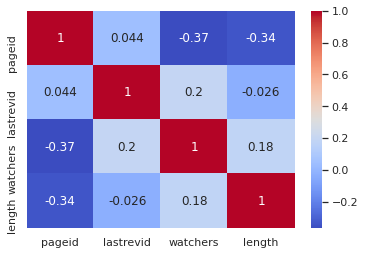

In [256]:
# TODO: add any imports of data analysis / visualization libraries here as necessary
#Visualize the correlation matrix in API data
import seaborn as sns
cor=api[['pageid','lastrevid','watchers','length']].corr() #Find out the correlation between API data continuous variables
sns.heatmap(cor, annot=True, cmap='coolwarm') 
plt.show()

In [142]:
api.columns

Index(['index', 'pageid', 'ns', 'title', 'contentmodel', 'pagelanguage',
       'pagelanguagehtmlcode', 'pagelanguagedir', 'touched', 'lastrevid',
       'length', 'restrictiontypes', 'watchers', 'type1', 'level1', 'expiry1',
       'expiry2', 'level2', 'type2', 'revid', 'parentid', 'minor', 'user',
       'timestamp', 'comment'],
      dtype='object')

,count,mean,std,min,25%,50%,75%,max
pageid,,,,,,,,
19644,1.0,497.0,NaN,497.0,497.0,497.0,497.0,497.0
1234398,1.0,66.0,NaN,66.0,66.0,66.0,66.0,66.0
1610318,1.0,71.0,NaN,71.0,71.0,71.0,71.0,71.0
5113872,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30610102,1.0,77.0,NaN,77.0,77.0,77.0,77.0,77.0
42376342,1.0,100.0,NaN,100.0,100.0,100.0,100.0,100.0
56693098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59720465,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


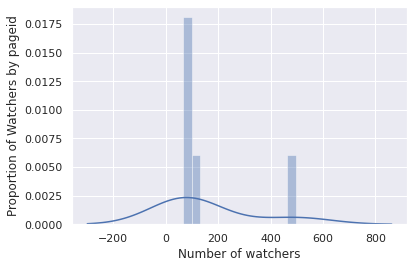

In [270]:
plt = sns.distplot(ap['watchers'], axlabel = 'Number of watchers')
_ = plt.set_ylabel('Proportion of Watchers by pageid')

ap.groupby('pageid')['watchers'].describe()

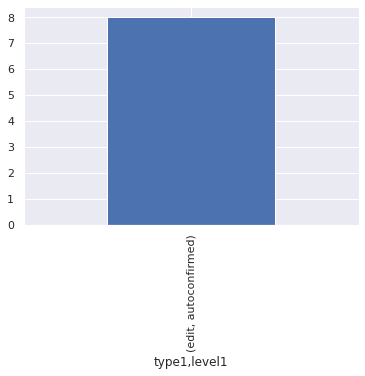

<Figure size 1080x1080 with 0 Axes>

In [269]:
api[['type1','level1']].value_counts().plot(kind= 'bar')
plt.figure(figsize=(15, 15))
plt.show() #this shows the values count for type and level 1 protections

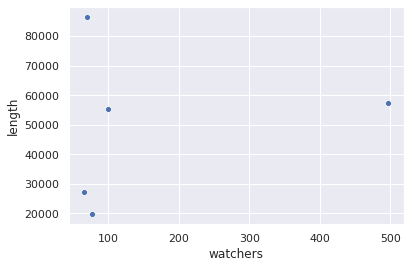

In [166]:
# Scatter plot of type and pageid; levels sysop and autoconfirmed separated out
plt = sns.scatterplot(x='watchers', y='length', data=api)

Since there are only a few data points in the API dataframe, the scatterplot is not very populated and doesn't show an explicit trend. So we will carry further analysis on the larger dump file data.

#### Analysis and Visualization of Dump File Data

The first few thousand  records of dump file is stored in a text file(due to memory constraints) and then converted to a dataframe, which will be used or descriptive statistics and predictive modelling.

In [76]:
import pandas as pd
import numpy as np

In [77]:
with open('untitled1.txt', 'r') as my_file: #this file contains the page restrctions from dump file
    text = my_file.read()
    text = text.replace("(", " ")
    text = text.replace("),", "\n") 
    text = text.replace(")", " ")
    text = text.replace("'","") 
# To save the updates back into a cleaned up file
    with open('cleanfile.txt', 'w') as my_file:
        my_file.write(text)

In [88]:
df = pd.read_csv("cleanfile.txt",header=None)
df.columns = ['pageid','type','level','cascade','user','expiry','key']
df.to_csv('page_restrictions.csv',index=None)

df

,pageid,type,level,cascade,user,expiry,key
0,1086732,edit,sysop,0,NaN,inf,1307
1,1086732,move,sysop,0,NaN,inf,1308
2,1266562,edit,autoconfirmed,0,NaN,inf,1358
3,1266562,move,autoconfirmed,0,NaN,inf,1359
4,1534334,edit,autoconfirmed,0,NaN,NaN,1437
...,...,...,...,...,...,...,...
4030,13516417,edit,sysop,0,NaN,inf,57276
4031,13516417,move,sysop,0,NaN,inf,57277
4032,8755415,edit,autoconfirmed,0,NaN,inf,57282
4033,8755415,move,sysop,0,NaN,inf,57283


Using a catplot, we see that there are approximately equal number of page ids with the 2 protection types and levels in dump data.

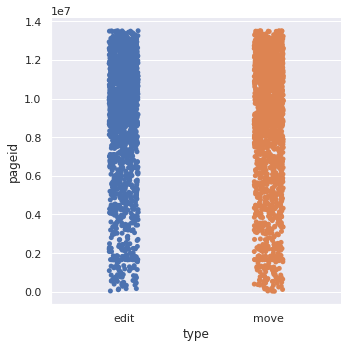

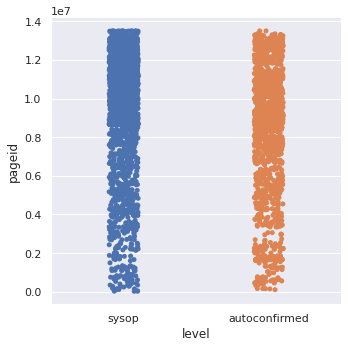

In [193]:
sns.catplot(x="type", y="pageid", data=df)
sns.catplot(x="level", y="pageid", data=df)

Boxplot() shows the three quartile values of the distribution along with extreme values. The “whiskers” extend to points that lie within 1.5 IQRs of the lower and upper quartile, and then observations that fall outside this range are displayed independently. This means that each value in the boxplot corresponds to an actual observation in the data.

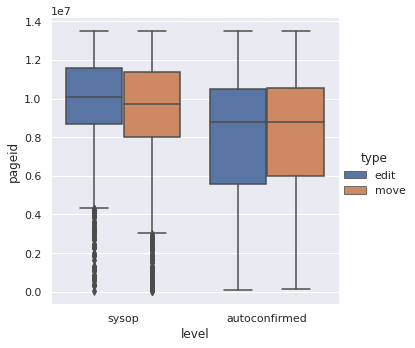

In [198]:
sns.catplot(x="level", y="pageid", hue="type", kind="box", data=df)

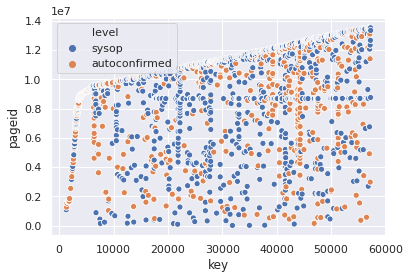

In [202]:
# Scatter plot of keys and ids; levels of protection separated out
plt = sns.scatterplot(x='key', y='pageid', hue='level', data=df)

Finding correlation matrix between numerical features

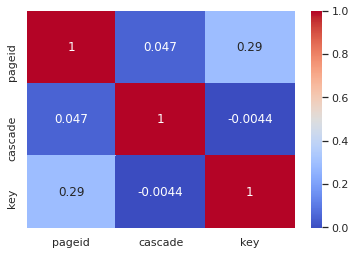

In [95]:
#TODO: give an overview of basic details about page protections and any conclusions 
#you reach based on the analyses you do below

import seaborn as sns
import matplotlib.pyplot as plt
cor=df[['pageid', 'cascade', 'key']].corr() #Find out the correlation between dump data
sns.heatmap(cor, annot=True, cmap='coolwarm') 
plt.show()

We find that above features are not strongly correlated

## Descriptive statistics


In [149]:
df.columns

Index(['pageid', 'type', 'level', 'cascade', 'user', 'expiry', 'key'], dtype='object')

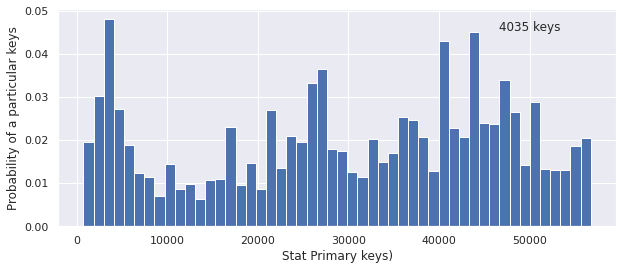

In [165]:

H, edges = np.histogram(df.key, bins=50)

plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
ax.bar(edges[:-1], H / float(sum(H)), width=edges[1] - edges[0])
ax.text(0.9, 0.9, "%g keys" % len(df),
        horizontalalignment="right", transform=ax.transAxes)
ax.set_xlabel("Stat Primary keys)")
ax.set_ylabel("Probability of a particular keys")
ax.minorticks_on()
plt.show()

We can see that most primary keys lie between range 0 and 10000

In [155]:
from scipy import stats
stats.normaltest(df['key'])

NormaltestResult(statistic=1904.6679920124886, pvalue=0.0)

In [89]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

from IPython.display import display

sns.set()

In [90]:
df.describe()


,pageid,cascade,user,expiry,key
count,4.035000e+03,4035.000000,0.0,3864.0,4035.000000
mean,8.867595e+06,0.005948,NaN,inf,30529.268897
std,3.218556e+06,0.076903,NaN,NaN,16361.890404
min,1.821200e+04,0.000000,NaN,inf,1307.000000
25%,7.563987e+06,0.000000,NaN,inf,17809.500000
50%,9.273574e+06,0.000000,NaN,inf,32506.000000
75%,1.128361e+07,0.000000,NaN,inf,44204.500000
max,1.351642e+07,1.000000,NaN,inf,57298.000000


In [91]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4035 entries, 0 to 4034
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pageid   4035 non-null   int64  
 1   type     4035 non-null   object 
 2   level    4035 non-null   object 
 3   cascade  4035 non-null   int64  
 4   user     0 non-null      float64
 5   expiry   3864 non-null   float64
 6   key      4035 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 220.8+ KB


In [92]:
df.isnull().sum()


pageid        0
type          0
level         0
cascade       0
user       4035
expiry      171
key           0
dtype: int64

In [93]:
# All items
print("Correlation (all items)")

scorr_coef, pval = spearmanr(df['type'], df['level'])
print("Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(scorr_coef, pval))

Correlation (all items)
Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: 0.058 (p=0.000)


In [204]:
df=df.drop(columns=['user'],axis=1) #Drop the entirely NULL column


In [205]:
df['type'].value_counts()


move    2076
edit    1959
Name: type, dtype: int64

In [206]:
df['level'].value_counts()


sysop            2539
autoconfirmed    1496
Name: level, dtype: int64

In [207]:
df['expiry'].value_counts()


inf    3864
Name: expiry, dtype: int64

In [280]:
df['cascade'].value_counts()


0    4011
1      24
Name: cascade, dtype: int64

In [281]:
cor=df.corr()
cor

,pageid,cascade,expiry,key
pageid,1.000000,0.046741,NaN,0.290275
cascade,0.046741,1.000000,NaN,-0.004371
expiry,NaN,NaN,NaN,NaN
key,0.290275,-0.004371,NaN,1.000000


In [282]:
#We can drop the expiry column
df=df.drop(columns=['expiry'],axis=1)

## Building Predictive Model

### Create Baseline Classification Model


In [283]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

When doing supervised learning, we can compare our estimator against simple rules of thumb. Here, DummyClassifier implements a uniform strategy for classification, which generates predictions uniformly at random.

In [284]:
X = df
y = df['level']
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Create dummy classifer
dummy = DummyClassifier(strategy='uniform', random_state=1)
# "Train" model
dummy.fit(X_train, y_train)
# Get accuracy score
dummy.score(X_test, y_test)


0.5014866204162537

So, the dummy classifier gives an accuracy of approximately 50% , our new model should perform better than this.

### Encoding the features

In [285]:
df.head() #the original dataframe

,pageid,type,level,cascade,key
0,1086732,edit,sysop,0,1307
1,1086732,move,sysop,0,1308
2,1266562,edit,autoconfirmed,0,1358
3,1266562,move,autoconfirmed,0,1359
4,1534334,edit,autoconfirmed,0,1437


In [286]:
#Make a copy of the datafram so that we can encode categorical features in the copied dataframe
do=df.copy()


In [287]:
#import libraries
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

#Use one hot and label encoding to transform categorical features to integer data
ohe = OneHotEncoder()
do['level']=pd.get_dummies(do['level'])
do['type']=pd.get_dummies(do['type'])
le = LabelEncoder()
do['pageid'] = le.fit_transform(do['pageid'])
do['key'] = le.fit_transform(do['key'])
do

,pageid,type,level,cascade,key
0,50,1,0,0,0
1,50,0,0,0,1
2,60,1,1,0,2
3,60,0,1,0,3
4,70,1,1,0,4
...,...,...,...,...,...
4030,2076,1,0,0,4030
4031,2076,0,0,0,4031
4032,877,1,1,0,4032
4033,877,0,0,0,4033


To do feature selection for machine learning we use logistic regression to understand association between categorical and continuous variable pair.

In [288]:
x = do[['type','pageid', 'key']] 

y = df['level'] 
lr = LogisticRegression()
lr.fit(x, y)
x


,type,pageid,key
0,1,50,0
1,0,50,1
2,1,60,2
3,0,60,3
4,1,70,4
...,...,...,...
4030,1,2076,4030
4031,0,2076,4031
4032,1,877,4032
4033,0,877,4033


In [289]:
type1 = lr.predict_proba(x) # predict the probability that the object belongs to a given class
level1 = lr.predict_proba(x) 
do['type'] = type1 
do['level'] = level1

In [290]:
do.corr()['level']


pageid    -0.999172
type       1.000000
level      1.000000
cascade   -0.048564
key       -0.369844
Name: level, dtype: float64

In [291]:
pcorr_coef, pval = pearsonr(do['type'], df['pageid'])
print("Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(pcorr_coef, pval))


Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: -0.958 (p=0.000)


Now we can see that level is strongly correlated with type and primary key.

### PREDICTING PROTECTION LEVELS

In [292]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
x = do[['type','key']]
y = df['level']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)


### Using GradientBoostingClassifier

In [293]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print('X_train:',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test', y_test.shape)
print(classification_report(y_test, pred))

print(clf.score(X_test,y_test)*100,'%')


X_train: (2824, 2)
X_test (1211, 2)
y_train (2824,)
y_test (1211,)
               precision    recall  f1-score   support

autoconfirmed       0.71      0.52      0.60       434
        sysop       0.77      0.88      0.82       777

     accuracy                           0.75      1211
    macro avg       0.74      0.70      0.71      1211
 weighted avg       0.75      0.75      0.74      1211

75.22708505367464 %


### USING A DECISION TREE CLASSIFIER

In [294]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [295]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(predictions)


['sysop' 'sysop' 'autoconfirmed' ... 'autoconfirmed' 'sysop' 'sysop']


In [296]:
print(classification_report(y_test, pred))
print(clf.score(X_test,y_test)*100,'%')


               precision    recall  f1-score   support

autoconfirmed       0.71      0.52      0.60       434
        sysop       0.77      0.88      0.82       777

     accuracy                           0.75      1211
    macro avg       0.74      0.70      0.71      1211
 weighted avg       0.75      0.75      0.74      1211

88.68703550784475 %


### Using RandomForestClassifier

In [297]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)

In [298]:
 from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=3, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=1)

In [299]:
predictions = clf.predict(X_test)
print(predictions)
print(classification_report(y_test, pred))
print(clf.score(X_test,y_test)*100,'%')

['autoconfirmed' 'sysop' 'sysop' ... 'autoconfirmed' 'autoconfirmed'
 'sysop']
               precision    recall  f1-score   support

autoconfirmed       0.71      0.52      0.60       434
        sysop       0.77      0.88      0.82       777

     accuracy                           0.75      1211
    macro avg       0.74      0.70      0.71      1211
 weighted avg       0.75      0.75      0.74      1211

71.2634186622626 %


### Further Analysis

Using the features from API calls, more relevant features can be used for a prediction problem.
